# Математическое моделирование. Лабораторная работа 2.

 **Выполнил**: Клебанов Д.А, группа 853501, Вариант 10

In [1]:
from math import factorial as fact
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns

**Задание 1**

Имеется простейшая $n$-канальная СМО с $m$ местами в очереди; интенсивность потока заявок $\lambda$, потока обслуживания $\mu$. Время пребывания заявки в очереди ограничено некоторым случайным сроком $T$, распределенным по показательному закону с параметром $\nu$. Если по истечению времени $T$ заявка не была передана на обслуживание, она покидает СМО необслуженной.

Построить имитационную модель СМО. Сравнить характеристики СМО, полученные в результате моделирования, с теоретическими характеристиками (финальные вероятности состояний, абсолютная пропускная способность, вероятность отказа, средние число заявок в СМО, среднее число заявок в очереди, среднее время пребывания заявки в СМО, среднее время пребывания заявки в очереди, среднее число занятых каналов).
Продемонстрировать работоспособность модели с помощью графиков и построить графики, показывающие установку стационарного режима СМО. Исследовать СМО при различных параметрах $n$, $m$, $\lambda$, $\mu$.


**Задание 1.1**

Построить имитационную модель СМО

In [2]:
class QueuingSystem:
    def __init__(self, n, m, lmd, mu, nu):
        self.n = n
        self.m = m
        self.lmd = lmd
        self.mu = mu
        self.nu = nu
        
        self.state = 0
        self.time = 0
        self._state_log = [(0, 0), ]
        
        self.forward_cnt = 0
        self.refuse_cnt = 0
        self.forward_times = []
        self.backward_times = []
    
    @property
    def state_log(self):
        return np.array(self._state_log)
    
    @property
    def backward_cnt(self):
        return len(self.backward_times)

    def get_forward_intensity(self):
        return self.lmd
    
    def get_backward_intensity(self):
        return min(self.state, self.n) * self.mu + max(self.state - self.n, 0) * self.nu
    
    def get_timedelta_by_intensity(self, intensity):
        if intensity == 0:
            return np.inf
        return np.random.exponential(1.0 / intensity)
    
    def process_forward(self, time_delta):
        self.time += time_delta
        self.forward_cnt += 1
        if self.state < self.n + self.m:
            self.state += 1
            self.forward_times.append(self.time)
        else:
            self.refuse_cnt += 1

    def process_backward(self, time_delta):
        self.state -= 1
        self.time += time_delta
        self.backward_times.append(self.time)
    
    def process_event(self):
        timedelta_forward = self.get_timedelta_by_intensity(self.get_forward_intensity())
        timedelta_backward = self.get_timedelta_by_intensity(self.get_backward_intensity())
        if timedelta_forward < timedelta_backward:
            self.process_forward(timedelta_forward)
        else:
            self.process_backward(timedelta_backward)
        self._state_log.append((self.state, self.time))
        
    @property
    def p(self):
        return self.lmd / self.mu
    
    @property
    def beta(self):
        return self.nu / self.mu
    
    def _tfp_multiplier(self, i):
        return self.p ** i / fact(i)
    
    def _tfp_denominator_product(self, i):
        return np.prod([(self.n + l * self.beta) for l in range(1, i + 1)])
    
    @property
    def theoretical_final_probabilities(self):
        multipliers = [self._tfp_multiplier(i) for i in range(self.n + 1)]
        p0_rest_part = sum([self.p ** i / self._tfp_denominator_product(i) for i in range(1, self.m + 1)])
        p0 = 1.0 / (sum(multipliers) + multipliers[self.n] * p0_rest_part)
        
        ans_n_part = list(map(lambda x: x * p0, multipliers))
        ans_rest_part = [p0 * multipliers[self.n] * self.p ** i / self._tfp_denominator_product(i) for i in range(1, self.m + 1)]
        return list(ans_n_part) + ans_rest_part
        
    @property
    def empirical_final_probabilities(self):
        counts = np.unique(self.state_log[:, 0], return_counts=True)[1]
        return counts / np.sum(counts)
    
    @property
    def theoretical_absolute_bandwidth(self):
        return self.lmd * (1.0 - self.theoretical_final_probabilities[self.n + self.m])

    @property
    def empirical_absolute_bandwidth(self):
        # return self.lmd * (1.0 - self.empirical_final_probabilities[self.n + self.m])
        return self.lmd * self.backward_cnt / self.forward_cnt

    @property
    def theoretical_refuse_probability(self):
        return self.theoretical_final_probabilities[self.n + self.m]
    
    @property
    def empirical_refuse_probability(self):
        return 1.0 - self.backward_cnt / self.forward_cnt

    @property
    def theoretical_average_orders_in_system(self):
        return sum([self.n * self.theoretical_final_probabilities[self.n + i] for i in range(1, self.m + 1)]) \
            + sum([i * self.theoretical_final_probabilities[i] for i in range(1, self.n + 1)])
        
    @property
    def empirical_average_orders_in_system(self):
        return np.sum(list(map(lambda x: min(x, self.n), self.state_log[:, 0]))) / self.state_log.shape[0]
    
    @property
    def theoretical_average_orders_in_queue(self):
        return sum([i * self.theoretical_final_probabilities[self.n + i] for i in range(1, self.m + 1)])
        
    @property
    def empirical_average_orders_in_queue(self):
        return np.sum(list(map(lambda x: max(x - self.n, 0), self.state_log[:, 0]))) / self.state_log.shape[0]
    
    @property
    def theoretical_average_order_time_in_system(self):
        return self.theoretical_average_orders_in_queue / self.lmd + self.theoretical_absolute_bandwidth / self.lmd / self.mu
        
    @property
    def empirical_average_order_time_in_system(self):
        return np.mean([self.backward_times[i] - self.forward_times[i] for i in range(len(self.backward_times))])
    
    @property
    def theoretical_average_order_time_in_queue(self):
        return self.theoretical_average_orders_in_queue / self.lmd
        
    @property
    def empirical_average_order_time_in_queue(self):
        return self.empirical_average_orders_in_queue / self.lmd
    

**Задание 1.2**

Сравнить характеристики СМО, полученные в результате моделирования, с теоретическими характеристиками (финальные вероятности состояний, абсолютная пропускная способность, вероятность отказа, средние число заявок в СМО, среднее число заявок в очереди, среднее время пребывания заявки в СМО, среднее время пребывания заявки в очереди, среднее число занятых каналов).

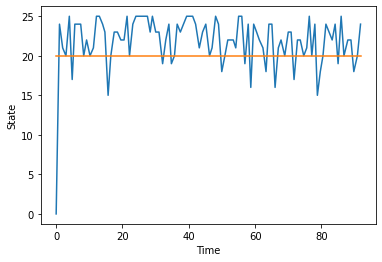

In [3]:
n_iter = 10000
system = QueuingSystem(20, 5, 60, 2, 4)
for _ in range(n_iter):
    system.process_event()
    
sampled_state_log = system.state_log[::n_iter // 100]

plt.plot(sampled_state_log[:, 1], sampled_state_log[:, 0], label='system state')
plt.plot(sampled_state_log[:, 1], [20] * sampled_state_log.shape[0], label='system channels')
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

> финальные вероятности состояний

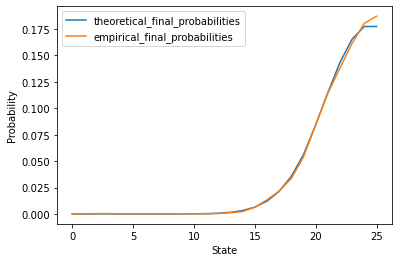

In [4]:
x_values = np.arange(system.n + system.m + 1)
for name in ('theoretical_final_probabilities', 'empirical_final_probabilities'):
    plt.plot(x_values, getattr(system, name), label=name)
plt.xlabel('State')
plt.ylabel('Probability')
plt.legend()
plt.show()

> абсолютная пропускная способность

In [5]:
print(f'Theoretical absolute bandwidth: {system.theoretical_absolute_bandwidth}')
print(f'Empirical absolute bandwidth: {system.empirical_absolute_bandwidth}')

Theoretical absolute bandwidth: 49.35767420168195
Empirical absolute bandwidth: 49.48905109489051


> вероятность отказа

In [6]:
print(f'Theoretical refuse probability: {system.theoretical_refuse_probability}')
print(f'Empirical refuse probability: {system.empirical_refuse_probability}')

Theoretical refuse probability: 0.17737209663863418
Empirical refuse probability: 0.17518248175182483


> средние число заявок в СМО

In [7]:
print(f'Theoretical average orders in system: {system.theoretical_average_orders_in_system}')
print(f'Empirical average orders in system: {system.empirical_average_orders_in_system}')

Theoretical average orders in system: 19.689399438417666
Empirical average orders in system: 19.675432456754326


> среднее число заявок в очереди

In [8]:
print(f'Theoretical average orders in queue: {system.theoretical_average_orders_in_queue}')
print(f'Empirical average orders in queue: {system.empirical_average_orders_in_queue}')

Theoretical average orders in queue: 2.494718831211652
Empirical average orders in queue: 2.5325467453254675


> среднее время пребывания заявки в СМО

In [9]:
print(f'Theoretical average order time in system: {system.theoretical_average_order_time_in_system}')
print(f'Empirical average order time in system: {system.empirical_average_order_time_in_system}')

Theoretical average order time in system: 0.4528925988675438
Empirical average order time in system: 0.44638749687537077


> среднее время пребывания заявки в очереди

In [10]:
print(f'Theoretical average order time in queue: {system.theoretical_average_order_time_in_queue}')
print(f'Empirical average order time in queue: {system.empirical_average_order_time_in_queue}')

Theoretical average order time in queue: 0.04157864718686087
Empirical average order time in queue: 0.042209112422091126


> среднее число занятых каналов

In [11]:
print(f'Theoretical average used channels: {system.theoretical_average_orders_in_system}')
print(f'Empirical average used channels: {system.empirical_average_orders_in_system}')

Theoretical average used channels: 19.689399438417666
Empirical average used channels: 19.675432456754326


**Задание 1.3**

Продемонстрировать работоспособность модели с помощью графиков и построить графики, показывающие установку стационарного режима СМО. Исследовать СМО при различных параметрах $n$, $m$, $\lambda$, $\mu$.


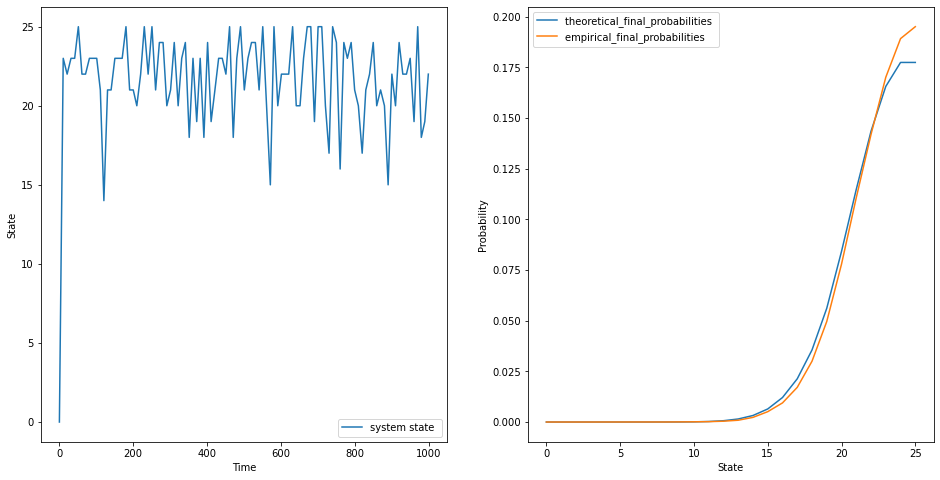

In [12]:
def emulate(ax, n, m, lmd, mu, nu, param_name="", value=None):
    max_time = 1000
    system = QueuingSystem(n, m, lmd, mu, nu)
    while system._state_log[-1][1] < max_time:
        system.process_event()

    sampled_state_log = system.state_log[::len(system._state_log) // 100]
    
    emulate_name = ""
    if value is not None:
        emulate_name = f'{param_name}={value}'
    
    ax[0].plot(sampled_state_log[:, 1], sampled_state_log[:, 0], label=f'system state {emulate_name}')
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('State')
    ax[0].legend()

    x_values = np.arange(system.n + system.m + 1)
    for name in ('theoretical_final_probabilities', 'empirical_final_probabilities'):
        ax[1].plot(x_values, getattr(system, name), label=name + ' ' + emulate_name)
    ax[1].set_xlabel('State')
    ax[1].set_ylabel('Probability')
    ax[1].legend()

# plt.figure()
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
emulate(ax, 20, 5, 60, 2, 4)
plt.show()

In [13]:
def brute_param(n, m, lmd, mu, nu, name, values):
    params = {
        "n": n,
        "m": m,
        "lmd": lmd,
        "mu": mu,
        "nu": nu,
        "param_name": name,
    }
    
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    for value in values:
        params[name] = value
        params["value"] = value
        emulate(ax, **params)
    plt.show()

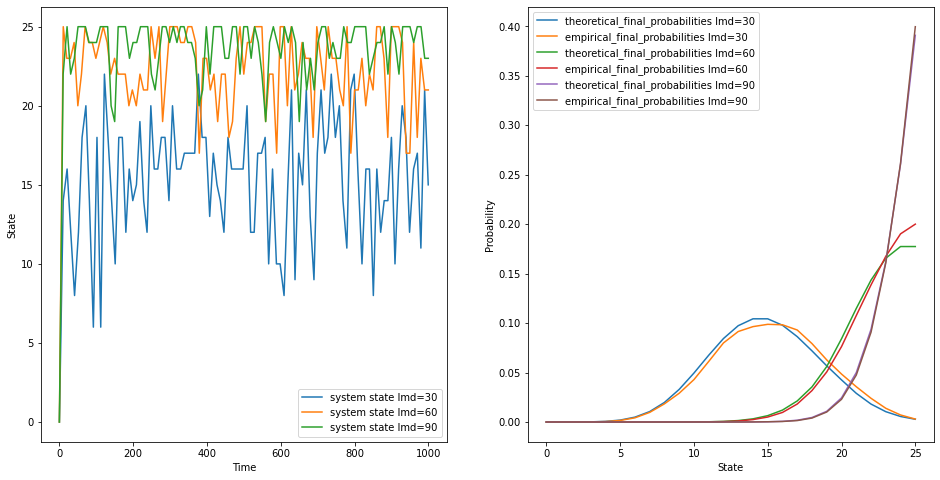

In [14]:
brute_param(20, 5, None, 2, 4, "lmd", (30, 60, 90))

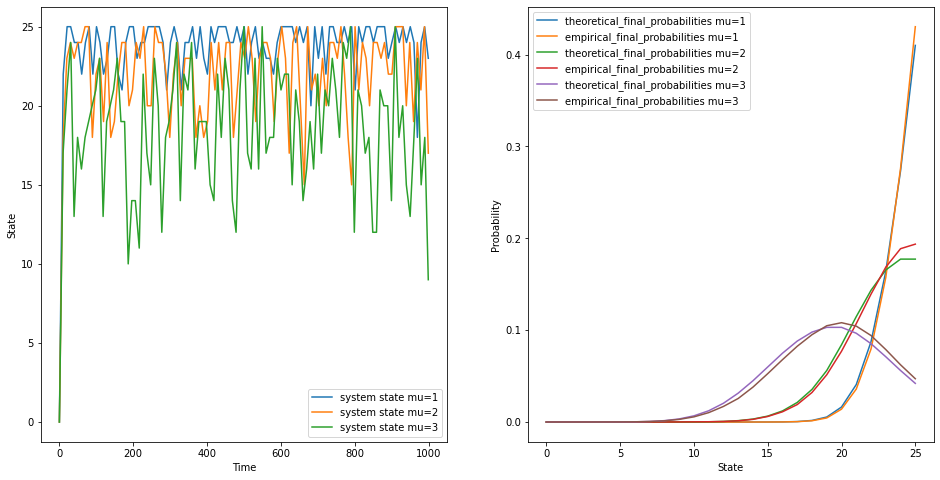

In [15]:
brute_param(20, 5, 60, None, 4, "mu", (1, 2, 3))

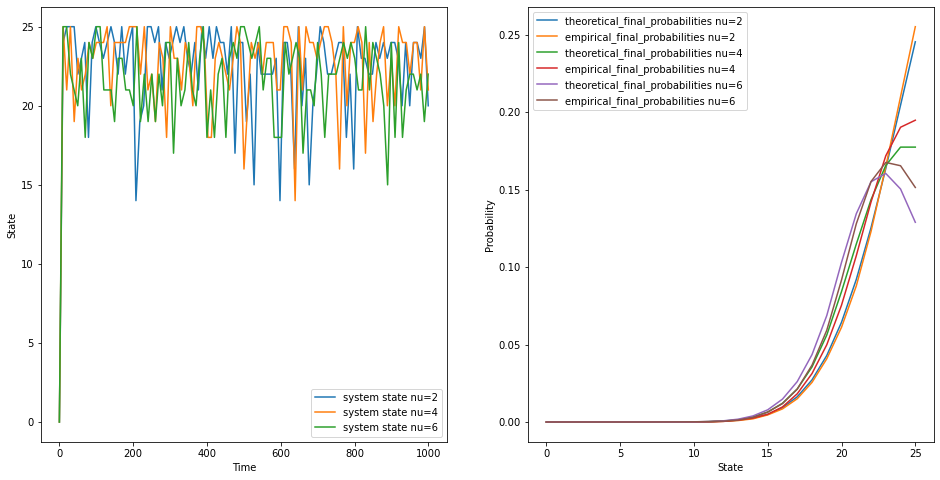

In [16]:
brute_param(20, 5, 60, 2, None, "nu", (2, 4, 6))

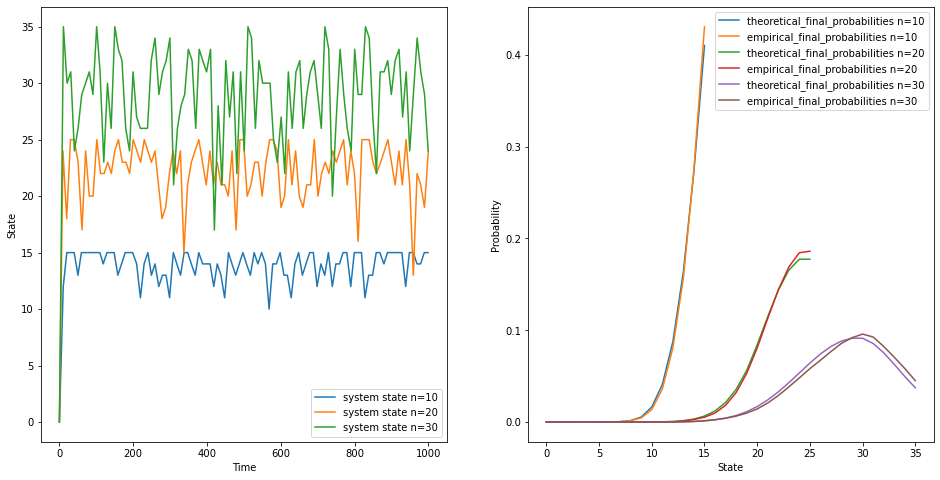

In [17]:
brute_param(None, 5, 60, 2, 4, "n", (10, 20, 30))

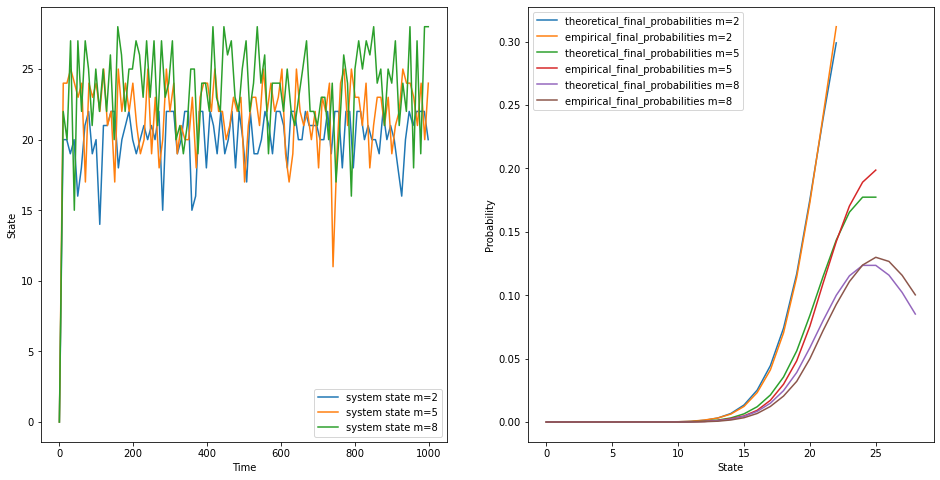

In [18]:
brute_param(20, None, 60, 2, 4, "m", (2, 5, 8))